# Discord Role Color Selection
I was setting up a Discord server not too long ago with some friends, and when all the important things were done, we had to assign colors to the different roles in the server sturcture. These are just colors that are applied to people's usernames, primarily for aesthetic and (in some cases) organizational purpose.

Nothing stops you from picking any color for a specific role, but I think there's a couple reasonable requirements for any role color;
- Roles should contrast well against Dark & Light mode backgrounds
- Roles should contrast well against other roles
- Roles should be distinguishable for colorblind people of all types
- Roles should be colors that are nice to look at; nobody wants to be vomit-colored

The last requirement is very hard to quantify, but the first two are pretty objective measures, all things considered. So, I thought, surely it couldn't be *that* hard to optimize.

In [ ]:
! pip install coloraide
! pip install scikit-optimize
from coloraide import Color
import numpy as np
import itertools
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

I could display colors as just hex codes, but I didn't want to have to grab the hex code and copy it into an editor every time I wanted to see a color. So I went on a side mission to figure out how to display colors in notebooks, and found out it's possible to inject HTML directly into a notebook with IPython!

In [2]:
from IPython.display import HTML
from typing import Literal
def print_color(color: Color, format: Literal['hex', 'rgb', 'oklch'] = 'hex', additional_text=""):
  match format:
    case 'hex':
      c = color.fit('srgb').convert('srgb').to_string(hex=True)
    case 'rgb':
      c = color.fit('srgb').convert('srgb').to_string()
    case 'oklch':
      c = color.to_string()
  display(HTML(f'<span style="color:{c}; background-color:#313338; padding-inline:10px">{c}{additional_text}</span>'))

Of course, we need to define all the colors that a new color needs to contrast against. So here I've listed a bunch of colors- most of these are role colors, and at the end we have a couple colors that match the background color used in Discord's layout.

Conveniently, this is also a really good way to show off the color display:

In [6]:
colors = []
role_colors = [
  "#000000",
  "#b20f95",
  "#2800ec",
  "#530000",
  "#05ffeb",
  "#ca0000",
  "#269d62",
  "#ff678f",
  "#7a2cc9",
  "#E74C3C",
  "#61FA94",
  "#E000FF",
  "#E5A400",
  "#B17FB8",
  "#43C0FF",
  '#313338', # Darkmode Background
  "#2B2D31", # ^
  "#FFFFFF"  # Whitemode Background
]
for hex in role_colors:
  color = Color(hex).convert("oklch")
  colors.append(color)

In [7]:
for color in colors:
  print_color(color, 'oklch')

So, how do we programmatically tell two colors apart?

The most logical first step would be the Euclidean distance of two colors- this works, but it's not very *perceptually uniform*- meaning colors with a distance of 50 might look more or less similar depending on where in the color space they are.

People smarter than me have been working on this for a long time, and they came up with the OKLCH color space. OKLCH defines three axes to define any color:
- Lightness (L): How bright a color is (0 = black, 1 = white)
- Chroma (C): How strong or saturated a color is
- Hue (H): The type of color (e.g., red, green, blue)

It also defines certain limits on these based on what colors we can actually perceive, as well as what a screen can actually display. These axes are set up to be intuitive and perceptually uniform- so if we shift the hue of a color, it *only* changes the hue, without affecting how bright the color is, or how strong the color appears to be.

You can see the more detailed explanation of why OKLCH is cool from [this article](https://evilmartians.com/chronicles/oklch-in-css-why-quit-rgb-hsl#comparing-oklch-with-other-css-color-formats).

While OKLCH isn't perfect, it's much more perceptually uniform than most spaces. So, when we take the euclidean distance in this space, we get a much more reliable quantification of the difference between colors.

That works pretty well, but we also need to account for colorblindness. Colorspacious has functionality for simulating colorblindness- no simulation is 100% accurate, but I don't have a colorblind person on hand to check this so this is the best I can do. For my purposes I'm checking the color differences assuming the maximum theoretical severity.

We take the minimum distance between the two colors in the usual color gamut as well as the constricted gamuts for different colorblindness types to get a final measure of distance:

In [10]:
# What the big explanation was about
def color_diff(color1: Color, color2: Color):
  diffs = [color1.delta_e(color2, method="ok")] # Normal Vision
  for filter in ['protan', 'deutan', 'tritan']: # Diff Colorlindness Types
    color1_t = color1.filter(filter)
    color2_t = color2.filter(filter)
    diffs.append(color1_t.delta_e(color2_t, method="ok"))
  return min(diffs) / 100

# Just a typical contrast ratio calculation, which gets scaled down for our purposes
def contrast_ratio(color1: Color, color2: Color):
  L1 = color1.convert("srgb").luminance()
  L2 = color1.convert("srgb").luminance()

  if L1 > L2:
    ratio = (L1 + 0.05) / (L2 + 0.05)
  else:
    ratio = (L2 + 0.05) / (L1 + 0.05)

  return (ratio - 1) / 20

color_diff(colors[1], colors[2]), contrast_ratio(colors[1], colors[2])

(0.0016645316755503356, 0.0)

To determine the fitness of a specific color against the entire set of existing colors, we take all the distances and all the contrast ratios, take the minimum of each and add them together.

Taking the minimum is important here- if it's far from one color but identical to another, that's just as bad as if it was indistinguishable from the entire set. (Though, that would be impressive in its own right to be fair)

In [13]:
def fitness(color: Color):
  diffs = []
  ratios = []
  # Difference Between competing colors
  for roleColor in colors:
    diffs.append(color_diff(color, roleColor))
    ratios.append(contrast_ratio(color, roleColor))

  fitness = 5 * (min(diffs) + min(ratios))

  return -fitness

print("Existing Color", fitness(Color("#2800EC", space='oklch')))
print("Orange", fitness(Color("#FF8930", space='oklch')))

Existing Color -4.3422263169012155e-18
Orange -0.0008815108035432732


Now that we have a way to measure the fitness of a given color, we can throw this into a Gaussian Process and get on our way. To do that though, we need to define some bounds.

These are mostly just properties of OKLCH, but while we're doing this, we can define some limits to at least attempt to avoid "ugly" colors. Colors with a Chroma value under 0.1, or a Lightness value under 0.5, don't look that great to me, so we'll set those as minima.

In [14]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.5, 1, name='L'),
          Real(0.1, 0.37, name='C'),
          Real(0, 360, name='H')]

@use_named_args(space)
def objective_function(L, C, H):
    # The color is "fitted" to the sRGB gamut but not actually converted- this
    # guarantees that our color will be possible in sRGB space and viewable
    # on basically any normal screen
    color = Color('oklch', [L, C, H]).fit('srgb')
    return fitness(color)

def callback(res):
  print(f"Iteration {len(res.func_vals)}")
  print(f" - OKLCH: {res.x}")
  color = Color('oklch', res.x).fit('srgb').convert('srgb')
  print_color(color)
  print(f" - Fitness {res.fun}")

Before we optimize though, we can look at the actual state space, since this isn't an insanely complex problem that can't be visually represented. This also helps us ensure that this isn't just a matter of simply maxing out any one parameter.

In [ ]:
resolution = 20
x0 = []
for dim in space:
  x0.append(np.linspace(dim.low, dim.high, resolution))
x0 = list(itertools.product(*x0))
y0 = [objective_function(x) for x in tqdm(x0)]

In [16]:
print("Min", x0[y0.index(min(y0))], y0[y0.index(min(y0))])
print("Max", x0[y0.index(max(y0))], y0[y0.index(max(y0))])

Min (0.868421052631579, 0.24210526315789474, 94.73684210526315) -0.005338737394354273
Max (0.9736842105263157, 0.2136842105263158, 170.52631578947367) -0.0


In [19]:
best_color = x0[y0.index(min(y0))]
best_color = Color('oklch', best_color).fit('srgb')
print_color(best_color, 'oklch')
print(best_color.coords())

[0.8690218596047952, 0.17773790908815992, 91.79869951365293]


In [ ]:
x0_df = pd.DataFrame(x0, columns=['Lightness', 'Chroma', 'Hue'])
# Create a 3D scatter plot
fig = px.scatter_3d(
    x0_df,
    x='Hue',
    y='Chroma',
    z='Lightness',
    color=[-y for y in y0],
    title='3D Scatter Plot of Parameters',
    labels={'Lightness': 'Lightness', 'Chroma': 'Chroma', 'Hue': 'Hue'},
    color_continuous_scale='Viridis'  # You can choose a different color scale
)

fig.show()

(Image attached because plotly shows a cool interactive thing, which I don't have implemented on the site)

As we might expect, Hue has the biggest impact on the fitness of a color- unfortunately we can also see that it's very nonlinear and *weird* in a linear space. Hue is typically represented in Degrees for a reason- it's a polar space, not a linear one.

I want to figure out if there's a better way to represent this for Machine Learning processes, but this is the best I've got so far. As we'll see in a second a Gaussian Process can still make sense of this, so that's cool

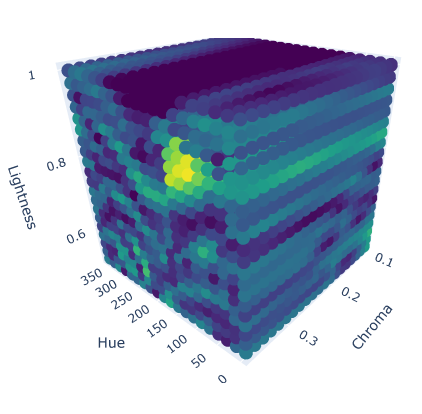

In [ ]:

result = gp_minimize(objective_function,
                      dimensions=space,
                      n_calls=100,
                      n_random_starts=5,
                      acq_func="LCB",
                      acq_optimizer="auto",
                      callback=[callback]
                  )
x0 = result.x_iters
y0 = result.func_vals

In [24]:
# Print the found minimum
print("Minimum of objective function:", result.fun)
print("Optimal parameters:", result.x)

out_color = Color('oklch', result.x).fit('srgb').convert('srgb')
print(out_color.to_string())
print_color(out_color)

Minimum of objective function: -0.005383975419532047
Optimal parameters: [0.8741500406886817, 0.37, 100.7201815207079]
rgb(254.84 208.96 0)


We end up at basically the same result- a bright yellow. It's cutting a bit close to the orange input color: `oklch(0.76092 0.15759 80.036)`, but this set is pretty challenging to find new colors for, so this is a pretty solid end result overall.

This came out pretty good off-rip for this example, but in some cases it'll give a ugly color, in which case I just have to manually change things around until it looks nice.

I want to mess around more with using the OKLCH color space and machine learning together- OKLCH is built to be intuitive and consistent, which notably is also helpful for ML models to make sense of the numbers they're getting. The challenge comes from representing Hue in a way that's at least *roughly* linear. In any case, that's a project for another time.